# Подход обучения с подкреплением для выявления релевантных предложений на претензии абонентов

<center> <img src = agent.bmp> </center>

# Выбор релевантного предложения осуществляет программный агент согласно CJ/Триггеру

## Цель системы:

- ### Многократно пробовать разные действия, делать вывод об их успешности, накапливать полученные знания и использовать их при следующем выборе;

- ### Формирование оптимальной (с точки зрения награды) стратегии поведения, в зависимости от ситуации

## Компоненты системы:

* ##  __Агент и Среда__ — это система взаимодействия, которая отправляет абоненту коммуникации, с предложениями, и сам абонент

* ##  __State__ — это состояние абонента, которое характеризуется CJ триггером и его профилем

* ##  __Actions__ — это активные действия в адрес абонента, маркетинговые предложения

* ##  __Reward__ — поощрение/наказание агента, как отклик на предложение

* ##  __Матрица обучения (States/Actions)__ — как аппарат обобщения опыта (знаний)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib as plt
#import matplotlib.pyplot as pyplot
from sklearn.metrics import confusion_matrix
import time
import seaborn as sns

from IPython import display

%matplotlib inline
pd.set_option('display.max_rows', 220)
pd.set_option("display.precision", 2)
pd.set_option('max_colwidth', 800)
    
from SOdataPrep import  *
from SORL import *
from SOdataRep import *

# Кол-во кластеров абонентов
n_classes = 5

In [2]:
compl = pd.read_excel('./data/complaint/ПСЛА неденежные 28.01 - 27.02_с номерами.xlsx', sheet_name='ПСЛА')
compl['MSISDN'] = compl['MSISDN'].apply(lambda x: int('7'+str(x))) ## Добавляем '7' для связки с MSISDN профиля абонента
complLeads = pd.read_csv('./data/complaint/leads_20210325.txt', sep='\t', na_values = '0')
complLeads, numCols, catCols= LeadsPreparation(complLeads)
## Кодирование catCols
complLeads, codeCols = encodingCatCols(complLeads, catCols)
## Масштабирование numCols
complLeads, scalCols = scalingNumCols(complLeads, numCols)

ATTR_NAMES = scalCols
complLeads = AddClusterField(complLeads.copy(), n_classes, ATTR_NAMES).copy()
## профиль абонентов под Претензии
complLeads = pd.merge(complLeads, compl, on='MSISDN')


C:\Users\SG186072\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## TOP 10 причин обращений

In [3]:

_S = complLeads[['MSISDN','Тема']].groupby(by=['Тема']).count().sort_values(by='MSISDN', ascending=False)[:10].reset_index()
_S = _S.append({'Тема':'Прочее', 'MSISDN':0}, ignore_index=True)
_S = _S.append({'Тема':'Отклик', 'MSISDN':0}, ignore_index=True)
_S = _S.append({'Тема':'Отказ', 'MSISDN':0}, ignore_index=True)
_S[:10]

,Тема,MSISDN
0,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,5327
1,"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",3610
2,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,3606
3,"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон",3186
4,"Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)",3112
5,Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,3013
6,Претензия устная\Тарифные планы\Для массового рынка\(для ИТ) Некорректное списание АП,1948
7,Недовольство\Интернет\Мобильный Интернет\Низкая скорость,1873
8,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности с управлением продуктами в ЛК/МЛК В2С,1605
9,Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала,1468


## TOP 10 предлагаемых пакетов

In [4]:

_A = complLeads[['MSISDN','Наименование пакета']].groupby(by=['Наименование пакета']).count().sort_values(by='MSISDN', ascending=False)[:10].reset_index()
_A

,Наименование пакета,MSISDN
0,100 мин на номера России (1 мес),7809
1,Скидка 50% по тарифу,4141
2,Скидка 30% по тарифу,3398
3,250 мин на номера России (1 мес),3305
4,Твои 20% на 3 месяца,3291
5,Скидка 20% по тарифу на 3 месяца,3152
6,Скидка 15% по тарифу на 3 месяца,2732
7,Скидка 30% по тарифу на полгода,2351
8,Твои 10% на 3 месяца,2248
9,Твои 10% на месяц,2095


## Q-martrix

In [5]:

Q = init_q(len(_S), len(_A), 'ones')
pdQ = pd.DataFrame(Q)
pdQ.index = _S['Тема']
pd.columns = _A['Наименование пакета']
pdQ.rename(columns = _A['Наименование пакета'], inplace=True)
HeatMapDataFrame(pdQ[:-3])

,100 мин на номера России (1 мес),Скидка 50% по тарифу,Скидка 30% по тарифу,250 мин на номера России (1 мес),Твои 20% на 3 месяца,Скидка 20% по тарифу на 3 месяца,Скидка 15% по тарифу на 3 месяца,Скидка 30% по тарифу на полгода,Твои 10% на 3 месяца,Твои 10% на месяц
Тема,,,,,,,,,,
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
"Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Претензия устная\Тарифные планы\Для массового рынка\(для ИТ) Некорректное списание АП,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Недовольство\Интернет\Мобильный Интернет\Низкая скорость,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности с управлением продуктами в ЛК/МЛК В2С,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [6]:
## expert Q-matrix 
pdQ = pd.DataFrame(expertQ)
pdQ.index = _S['Тема']
pd.columns = _A['Наименование пакета']
pdQ.rename(columns = _A['Наименование пакета'], inplace=True)
HeatMapDataFrame(pdQ[:-3])

NameError: name 'expertQ' is not defined

In [6]:
## Ограничение данных для анализа 
#complLeads = complLeads.drop(columns = ['level_0','index']) ## Если ранее уже добавлены колонки
complLeads = complLeads.sort_values(by='Начальная дата', ascending=True).reset_index(drop=True) 
complLeadsShort = complLeads[(complLeads['Тема'].isin(_S['Тема'])) & (complLeads['Наименование пакета'].isin(_A['Наименование пакета']))].copy()
pd.set_option('display.max_rows', 25)
pd.set_option("display.precision", 2)
complLeadsShort = complLeadsShort.sort_values(by='Начальная дата', ascending=True).reset_index(drop=True).copy()
complLeadsShort.iloc[:10][['MSISDN','Наименование пакета', 'Начальная дата', 'Тема']]
#complLeadsShort = complLeadsShort.drop(columns = ['level_0','index']) 

,MSISDN,Наименование пакета,Начальная дата,Тема
0,79246698062,Скидка 20% по тарифу на 3 месяца,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
1,79242889776,Скидка 20% по тарифу на 3 месяца,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
2,79384336258,Скидка 15% по тарифу на 3 месяца,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
3,79270028149,Скидка 30% по тарифу на полгода,2021-01-28 02:56:25.000003,Претензия устная\Интернет\Мобильный Интернет\Низкая скорость
4,79272579802,Скидка 20% по тарифу на 3 месяца,2021-01-28 03:20:40.000004,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
5,79247695702,Скидка 15% по тарифу на 3 месяца,2021-01-28 05:15:28.000002,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
6,79231241643,100 мин на номера России (1 мес),2021-01-28 05:32:19.000003,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С
7,79275876317,100 мин на номера России (1 мес),2021-01-28 05:32:19.000003,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С
8,79245938889,100 мин на номера России (1 мес),2021-01-28 05:32:19.000003,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С
9,79209763686,100 мин на номера России (1 мес),2021-01-28 05:32:19.000003,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С


In [10]:
complLeadsShort1.iloc[:episodes]

,MSISDN,LIFE_TIME,CURRENT_AGE,RATE_PLAN,SUBS_STATUS,HOME_TOWN,DEVICE_TYPE,OS,MASTER_SEGMENT,BUSINESS_SEGMENT,ARPU_3M,ARPU_1M,BALANCE_MAX,BALANCE_MIN,BALANCE_AVG,...,BALANCE_SKEW_scaled,VOICE_scaled,SMS_scaled,MMS_scaled,DATA_scaled,FOUR_G_scaled,class,Филиал,Сегмент рынка,Наименование пакета,Лицевой счет,Класс клиента,Начальная дата,Тема,Канал
0,79246698062,245,59,Без переплат. Всё 08.20,Активен,Приморский,SMARTPHONE,Android,B2C,B2B LA,883.17,755.20,1575.55,820.35,1334.00,...,0.52,4.54e-04,2.61e-04,0.00e+00,2.31e-04,0.00e+00,0,Дальневосточный филиал,B2C,Скидка 20% по тарифу на 3 месяца,843079161242,Базовый,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ
1,79242889776,1796,40,Включайся! Общайся Акция 11.18,Активен,Сахалинская область,SMARTPHONE,Android,B2C,B2B LA,661.77,608.00,10.05,0.05,9.73,...,0.52,1.45e-02,1.27e-02,0.00e+00,9.15e-04,8.25e-03,2,Дальневосточный филиал,B2C,Скидка 20% по тарифу на 3 месяца,870020976422,Базовый,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ
2,79384336258,145,26,Без переплат. Максимум,Активен,Коноково,SMARTPHONE,Android,B2C,B2B LA,494.67,552.50,102.05,9.55,99.07,...,0.52,1.97e-02,1.07e-02,0.00e+00,1.18e-02,5.82e-03,0,Кавказский филиал,B2C,Скидка 15% по тарифу на 3 месяца,453084745612,Базовый,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ
3,79270028149,5140,35,Без переплат. Максимум 12.20,Финансовая блокировка,Шентала,SMARTPHONE,Android,B2B,B2B SME,483.67,308.00,248.75,-101.25,110.91,...,0.52,1.43e-02,1.06e-02,0.00e+00,1.00e-02,0.00e+00,4,Поволжский филиал,B2C,Скидка 30% по тарифу на полгода,580010220138,Базовый,2021-01-28 02:56:25.000003,Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,КЦ
4,79272579802,216,35,Базовый,Добровольная блокировка,Волгоградская область,PHONE,Proprietary,B2G,B2G REG,1146.50,573.97,5024.46,-83.71,323.01,...,0.52,4.54e-05,3.81e-05,0.00e+00,1.57e-05,1.23e-05,0,Поволжский филиал,B2C,Скидка 20% по тарифу на 3 месяца,573076787989,Базовый,2021-01-28 03:20:40.000004,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,79282777895,1531,32,Без переплат. Максимум 12.20,Активен,Дагестан,SMARTPHONE,iOS,B2C,B2B LA,1029.00,780.00,104.86,-92.64,72.20,...,0.52,4.46e-02,2.22e-02,0.00e+00,1.12e-02,1.94e-02,2,Кавказский филиал,B2C,Твои 20% на 3 месяца,413049999498,Золотой,2021-02-17 14:15:51.999996,Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,ФРП
9996,79372016000,2093,32,Включайся! Смотри 04.20,Активен,Красноармейское,SMARTPHONE,Android,B2C,B2B LA,629.00,580.00,51.18,1.18,28.60,...,0.52,4.17e-02,4.27e-02,0.00e+00,1.34e-02,1.80e-02,2,Поволжский филиал,B2C,Скидка 15% по тарифу на 3 месяца,510017916746,Базовый,2021-02-17 14:19:08.000003,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ
9997,79221432886,5673,38,VIP 08.20,Активен,Свердловская,SMARTPHONE,iOS,B2C,B2B LA,937.27,928.80,945.27,25.49,392.44,...,0.52,9.34e-03,6.78e-03,8.80e-03,3.38e-03,2.66e-03,4,Уральский филиал,B2C,Скидка 20% по тарифу на 3 месяца,690002708975,Золотой,2021-02-17 14:25:25.000000,Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала,SBMS прочее
9998,79243522526,3468,57,Ультра,Финансовая блокировка,Каменск,SMARTPHONE,Funtouch OS,B2B,B2B SME,510.73,223.50,331.96,-363.04,-44.83,...,0.52,9.40e-03,1.08e-02,0.00e+00,4.55e-03,7.68e-03,3,Дальневосточный филиал,B2C,Скидка 50% по тарифу,860006216832,Золотой,2021-02-17 14:28:00.000002,"Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)",КЦ


In [13]:
topic = 'Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)'

In [76]:
topic

'Недовольство\\Тарифные планы\\Для массового рынка\\Требование возврата АП (не использовал, ошибочно подключил)'

In [14]:
%%time
episodes = 10000
## Random modeling
complLeadsShort1 = complLeadsShort.copy()
complLeadsShort1, convHist1, Q = mainRL(_S, _A, topic, complLeadsShort1, 0, episodes,)
def PosPerc(_vals):    
    posSum = sum([(1 if i>0 else 0) for i in _vals])
    return posSum/len(_vals)

## Save results of random-managed strategy for comparison and Lift demonstration
convPack1 = complLeadsShort1[:episodes].groupby('packUsed').agg({'MSISDN':len, 'reward':PosPerc})
convTopic1 = complLeadsShort1[:episodes].groupby('Тема').agg({'MSISDN':len, 'reward':PosPerc})

Wall time: 39.8 s


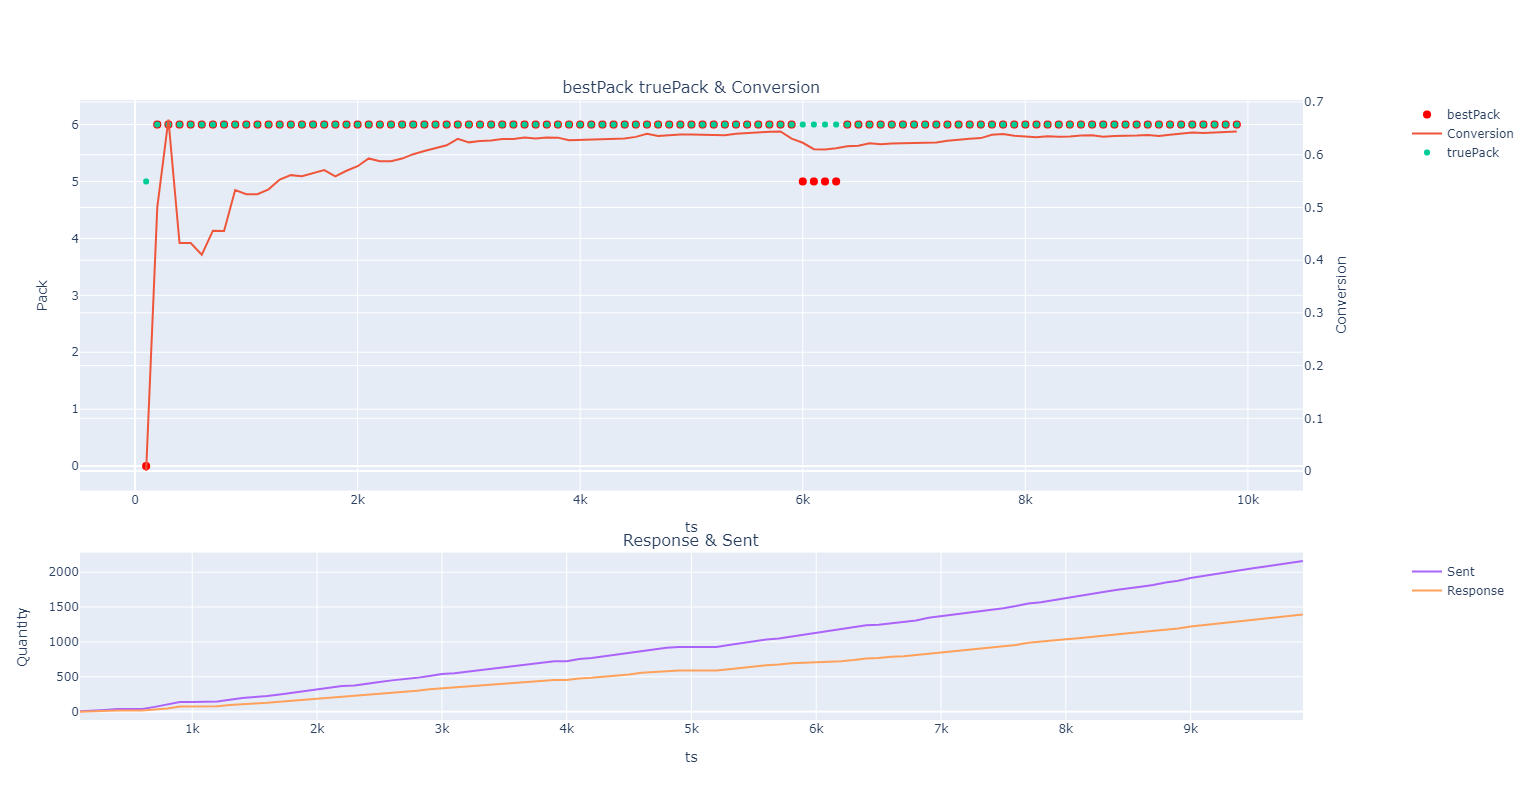

Wall time: 59.3 s


In [75]:
%%time
## Agent modeling
episodes = 10000
complLeadsShort2 = complLeadsShort.copy()
complLeadsShort2, convHist, Q2 = mainRL(_S, _A, topic, complLeadsShort2, 0.95, episodes, None, ConvCount, PrepQ, DrawDynamicChart, True,)
#complLeadsShort2, convHist2, Q2 = mainRL(_S, _A, topic, complLeadsShort2, 0.99, episodes, )


In [19]:
ConvCount(complLeadsShort2[(complLeadsShort2['Тема'] == 'Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана')
& (complLeadsShort2.index >= 0)
& (complLeadsShort2.index <= 300)], 10,1)

#complLeadsShort2[complLeadsShort2.index == 349]

KeyError: 0

In [22]:
complLeadsShort2[(complLeadsShort2['Тема'] == 'Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана')][:10]

,MSISDN,LIFE_TIME,CURRENT_AGE,RATE_PLAN,SUBS_STATUS,HOME_TOWN,DEVICE_TYPE,OS,MASTER_SEGMENT,BUSINESS_SEGMENT,ARPU_3M,ARPU_1M,BALANCE_MAX,BALANCE_MIN,BALANCE_AVG,...,Класс клиента,Начальная дата,Тема,Канал,pred,trueA,A,S,reward,nextS,nextA,prob,packUsed,maxA,Q
0,79246698062,245,59,Без переплат. Всё 08.20,Активен,Приморский,SMARTPHONE,Android,B2C,B2B LA,883.17,755.20,1575.55,820.35,1334.00,...,Базовый,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,0.0,5.0,0.0,2.0,-1.0,12.0,0.0,0.62,100 мин на номера России (1 мес),0.0,0.6
1,79242889776,1796,40,Включайся! Общайся Акция 11.18,Активен,Сахалинская область,SMARTPHONE,Android,B2C,B2B LA,661.77,608.00,10.05,0.05,9.73,...,Базовый,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,0.0,5.0,1.0,2.0,-1.0,12.0,0.0,0.21,Скидка 50% по тарифу,1.0,0.6
2,79384336258,145,26,Без переплат. Максимум,Активен,Коноково,SMARTPHONE,Android,B2C,B2B LA,494.67,552.50,102.05,9.55,99.07,...,Базовый,2021-01-28 00:00:00.000000,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,0.0,6.0,2.0,2.0,-1.0,12.0,0.0,0.55,Скидка 30% по тарифу,2.0,0.6
4,79272579802,216,35,Базовый,Добровольная блокировка,Волгоградская область,PHONE,Proprietary,B2G,B2G REG,1146.50,573.97,5024.46,-83.71,323.01,...,Базовый,2021-01-28 03:20:40.000004,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,0.0,5.0,3.0,2.0,-1.0,12.0,0.0,0.61,250 мин на номера России (1 мес),3.0,0.6
5,79247695702,2455,38,Без переплат. Интернет 12.20,Активен,Республика Саха (Якутия),SMARTPHONE,Android,B2C,B2B LA,487.17,425.00,47.64,22.64,33.12,...,Базовый,2021-01-28 05:15:28.000002,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,0.0,6.0,4.0,2.0,-1.0,12.0,0.0,0.42,Твои 20% на 3 месяца,4.0,0.6
188,79242042150,4792,58,Без переплат. Всё,Активен,Хабаровский край,SMARTPHONE,Android,B2C,B2B LA,784.67,0.00,181.59,-854.41,114.75,...,Золотой,2021-01-28 06:08:54.000004,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,1.0,5.0,5.0,2.0,1.0,11.0,0.0,0.23,Скидка 20% по тарифу на 3 месяца,5.0,1.0
191,79241720493,5091,39,Включайся! Развлекайся 01.20,Активен,Айхал,SMARTPHONE,Android,B2C,B2B LA,429.70,382.50,1309.35,809.35,1228.79,...,Базовый,2021-01-28 06:34:44.999996,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,0.0,6.0,5.0,2.0,-1.0,12.0,0.0,0.89,Скидка 20% по тарифу на 3 месяца,5.0,0.6
192,79234410440,2676,36,VIP 08.20,Активен,Томская,SMARTPHONE,iOS,B2C,B2B LA,887.00,789.00,81.74,-418.26,45.74,...,Золотой,2021-01-28 06:47:43.000002,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,1.0,6.0,6.0,2.0,1.0,11.0,0.0,0.50,Скидка 15% по тарифу на 3 месяца,6.0,1.0
193,79247133774,1268,36,VIP,Активен,Маркова,SMARTPHONE,iOS,B2C,B2B LA,670.70,581.00,-669.93,-960.93,-801.64,...,Базовый,2021-01-28 06:58:59.000004,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,1.0,6.0,6.0,2.0,1.0,11.0,0.0,0.86,Скидка 15% по тарифу на 3 месяца,6.0,1.0
195,79373553925,237,21,Без переплат. Максимум 08.20,Активен,Шереметьево Международный Аэропорт,SMARTPHONE,Android,B2C,B2B LA,623.50,552.50,49.60,2.10,5.16,...,Базовый,2021-01-28 07:06:57.999998,Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,КЦ,1.0,6.0,6.0,2.0,1.0,11.0,0.0,0.24,Скидка 15% по тарифу на 3 месяца,6.0,1.0


In [63]:
convHist[convHist.index== ('Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана', 340)]

,,Response,Sent,bestPack,truePack,Conversion,Learning rate
topic,ts,,,,,,
Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,340,14.0,27.0,6.0,6.0,0.52,0


In [26]:
ConvCount(complLeadsShort2, 100, 10)

KeyError: 0

,MSISDN,LIFE_TIME,CURRENT_AGE,RATE_PLAN,SUBS_STATUS,HOME_TOWN,DEVICE_TYPE,OS,MASTER_SEGMENT,BUSINESS_SEGMENT,ARPU_3M,ARPU_1M,BALANCE_MAX,BALANCE_MIN,BALANCE_AVG,...,Класс клиента,Начальная дата,Тема,Канал,pred,trueA,A,S,reward,nextS,nextA,prob,packUsed,maxA,Q
24,79258598277,4254,31,VIP,Активен,Московская область,SMARTPHONE,Android,B2C,B2B LA,740.25,822.35,688.36,166.01,354.96,...,Золотой,2021-01-28 05:32:19.000003,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,ФРИМАН,0.0,0.0,2.0,0.0,-1.0,12.0,0.0,0.99,Скидка 30% по тарифу,0.0,0.6
26,79377417332,2530,31,Включайся! Развлекайся 11.19,Активен,Чернышковский,SMARTPHONE,Android,B2C,B2B LA,395.63,370.00,436.48,36.48,53.25,...,Базовый,2021-01-28 05:32:19.000003,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,ФРИМАН,0.0,0.0,1.0,0.0,-1.0,12.0,0.0,0.99,Скидка 50% по тарифу,0.0,0.6
170,79207606821,731,28,Включайся! Общайся 03.19,Активен,Кизляр,SMARTPHONE,Android,B2C,B2B LA,465.67,320.00,838.97,58.97,140.91,...,Базовый,2021-01-28 05:32:23.000004,Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,ФРИМАН,0.0,0.0,9.0,0.0,-1.0,12.0,0.0,1.00,Твои 10% на месяц,0.0,0.6
214,79275710450,2418,70,Включайся! Для тебя+,Активен,Ивановка,SMARTPHONE,Android,B2C,B2B LA,310.00,280.00,444.32,94.32,184.64,...,Базовый,2021-01-28 09:19:49.000002,Недовольство\Интернет\Мобильный Интернет\Низкая скорость,КЦ,0.0,4.0,3.0,7.0,-1.0,12.0,0.0,0.99,250 мин на номера России (1 мес),1.0,0.6
364,79228205073,355,32,Без переплат. Максимум,Активен,Раннее,SMARTPHONE,Android,B2C,B2B LA,301.47,350.00,443.45,93.45,398.29,...,Базовый,2021-01-28 11:21:50.999996,"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",КЦ,0.0,1.0,5.0,1.0,-1.0,12.0,0.0,0.99,Скидка 20% по тарифу на 3 месяца,4.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19062,79280535444,5783,32,Без переплат. Всё 08.20,Активен,Айникабмахи,SMARTPHONE,Android,B2C,B2B LA,325.23,502.70,93.73,93.73,93.73,...,Базовый,2021-02-27 21:58:24.999998,Претензия устная\Тарифные планы\Для массового рынка\(для ИТ) Некорректное списание АП,КЦ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19063,79273851579,5721,43,Без переплат. Максимум,Активен,Пензенская область,SMARTPHONE,Android,B2C,B2B LA,703.47,719.40,-1057.56,-1522.36,-1176.06,...,Базовый,2021-02-27 22:16:13.999999,"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон",КЦ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19064,79274433919,4614,37,Тёплый приём S,Активен,Республика Татарстан (Татарстан),SMARTPHONE,Android,B2C,B2B LA,705.67,950.00,475.03,-274.97,-14.65,...,Базовый,2021-02-27 23:01:01.000004,"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",КЦ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19065,79213991224,4042,32,VIP,Активен,Верево,SMARTPHONE,Android,B2C,B2B LA,289.56,31.67,-18.67,-814.00,-508.73,...,Золотой,2021-02-27 23:23:04.999998,"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон",Другое,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
## Адаптивность лучше ли по сравнению с одним явным действием.?  - Не очевидно!!!
expertQ = Q.copy()
expertRate = 100 ## Уверенность эксперта
## Comparing strategy of the one most frequent action vs. strategy of the agent choosing action

for  topicId, topic in _S['Тема'][:-3].items():
    print('\nTopic: ', topic)
    _qTrue = complLeadsShort2.iloc[:episodes][complLeadsShort2.iloc[:episodes]['Тема'] == topic][['trueA', 'A', 'pred']].groupby(by='trueA').agg({'A':len}).copy()
    _qTrue.columns = ['trueQ']
    _pTrue = (_qTrue /_qTrue.sum()).copy()
    _pTrue.columns = ['trueP']

    _q = complLeadsShort2.iloc[:episodes][complLeadsShort2.iloc[:episodes]['Тема'] == topic][['trueA', 'A', 'pred']].groupby(by='A').agg({'pred':[sum, len]}).copy()
    _q.columns = ['respQ', 'sentQ'] 
    _q['conv'] = _q.apply(lambda x: x['respQ']/x['sentQ'], axis=1)
    #pd.concat((_qTrue, _pTrue, _q), axis=1)

    ## get the id of the most frequent action 
    freqA = _qTrue['trueQ'].idxmax()
    
    ## Change learning rate of the most frequent action per situation according to expertRate
    
    freqA = int(freqA) - 1 if int(freqA) > 0 else 0 
    expertQ[topicId, int(freqA)] = expertRate

    print('Conversion by only MAX frequent action: ',freqA,  ' management: ', _qTrue.loc[freqA]['trueQ']/_qTrue['trueQ'].sum())
    print('Conversion by agent management: ', _q['respQ'].sum()/_q['sentQ'].sum())


Topic:  Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С
Conversion by only MAX frequent action:  0  management:  0.861904761904762
Conversion by agent management:  0.8476190476190476

Topic:  Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)
Conversion by only MAX frequent action:  6  management:  0.026359143327841845
Conversion by agent management:  0.28747940691927515

Topic:  Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
Conversion by only MAX frequent action:  5  management:  0.24079189686924493
Conversion by agent management:  0.6758747697974218

Topic:  Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон
Conversion by only MAX frequent a

In [34]:
%%time
## Expert modeling
complLeadsShort0 = complLeadsShort.copy()
complLeadsShort0, convHist0, expertQ = mainRL(_S, _A, topic, complLeadsShort0, 1, episodes, _Q=expertQ.copy(), _Learn=False)

## Save results of expert-managed strategy for comparison and Lift demonstration

convPack0 = complLeadsShort0[:episodes].groupby('packUsed').agg({'MSISDN':len, 'reward':PosPerc})
convTopic0 = complLeadsShort0[:episodes].groupby('Тема').agg({'MSISDN':len, 'reward':PosPerc})

Wall time: 36.9 s


In [41]:
## for test issue
_df = complLeadsShort.copy()
def myMode(_vals):
        return (int)(pd.Series.mode(_vals)[0]) 

conv = _df.groupby(by =['Тема']).agg({'pred':(sum, len), 'maxA':myMode, 'trueA':myMode}).copy()   
conv[('pred', 'perc')] = conv.apply(lambda x: x[('pred', 'sum')]/x[('pred', 'len')], axis=1)
conv=conv.reset_index()
#conv.columns=[ 'topic','Response','Sent','bestPack','truePack', 'Conversion']
#conv.columns = conv.columns.droplevel() ## !!!drop columns name level, which been added after group by!!!


#conv = conv.set_index(['topic', 'ts'])
conv


KeyError: "Column 'pred' does not exist!"

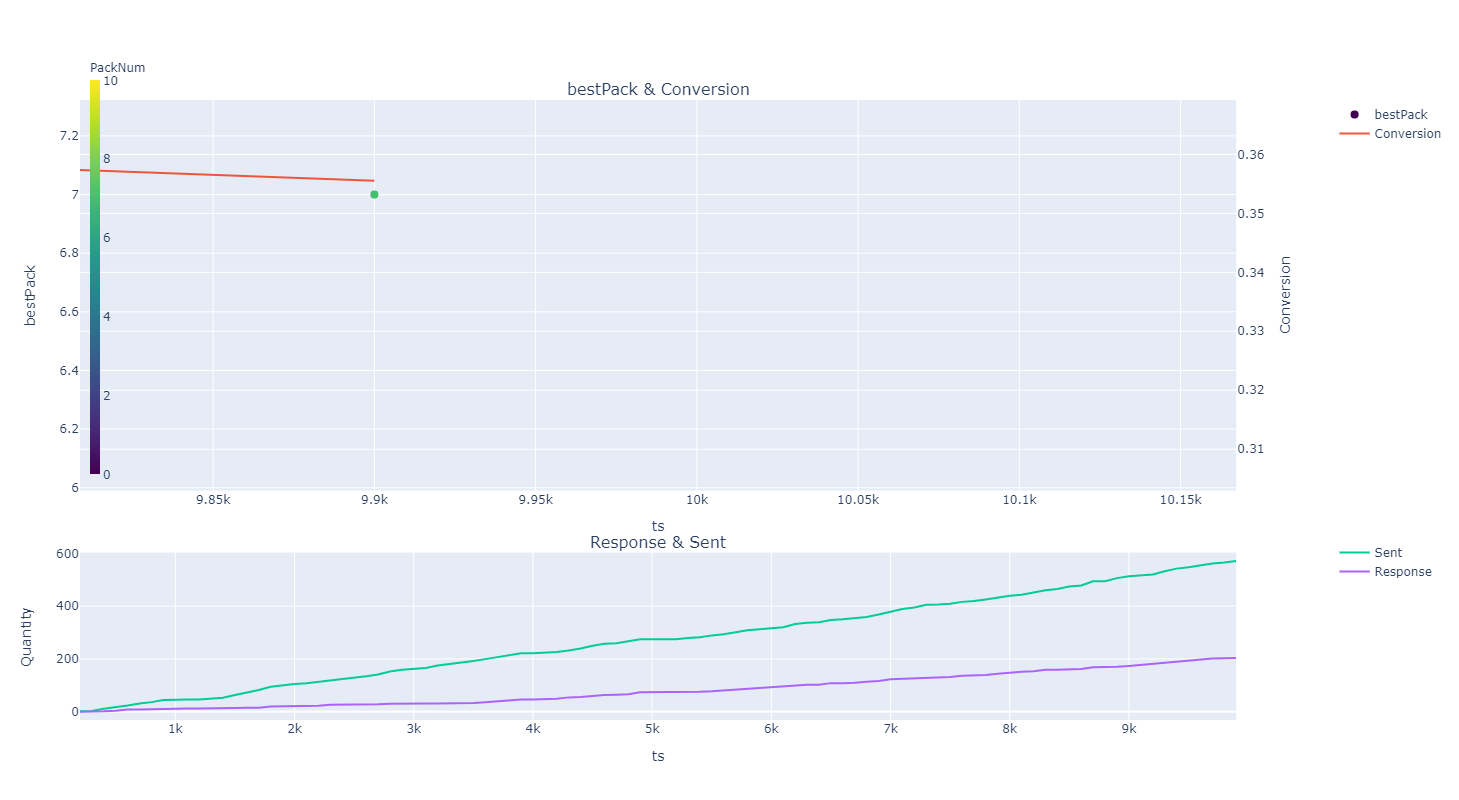

Wall time: 58.4 s


In [9]:
%%time
import plotly.express as px
## Main procerure
alpha = 0.4 ## это фактор обучения. Чем он выше, тем сильнее агент доверяет новой информации
gamma = 0.999 ## это фактор дисконтирования. Чем он меньше, тем меньше агент задумывается о выгоде от будущих своих действий
epsilon = 0.95## вероятность выбора лучшего действия в epsilon-жадной стратегии
episodes = 10000#len(complLeadsShort)
episodesChunkShowQ = 100
max_steps = 1
#n_tests = 20

n_actions = len(_A)
render = False
timestep_reward = []
test = True
Q = init_q(len(_S), len(_A), 'ones')

convHist = pd.DataFrame()
Qhist = pd.DataFrame()

for index, episode in complLeadsShort.iloc[:episodes].iterrows():
        sName = episode['Тема']
        s =  _S[_S['Тема'] == sName].index if  len(_S[_S['Тема'] == sName].index) > 0 else  len(_S)-1
        if render:
            print(f"Episode MSISDN: {episode['MSISDN']}, state: {s[0]}, state:{sName}, episode:{index}")
        total_reward = 0
        a,prob_ = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0        
        done = False
        while t < max_steps:
            #if render:
             #   env.render()
            t += 1
            # Get real true action, which been applied
            aTrue = _A[_A['Наименование пакета'] == episode['Наименование пакета']].index
            #reward = -1 if a != aTrue else 10 
            s_, reward, done, info = MyStep(a,s[0],aTrue[0],len(_S)-1)

            if render:
                print(info)
            total_reward += reward
            a_, probNext = epsilon_greedy(Q, epsilon, n_actions, s_)
            complLeadsShort.loc[index, 'pred'] = done
            complLeadsShort.loc[index, 'trueA'] = aTrue[0]
            complLeadsShort.loc[index, 'A'] = a
            complLeadsShort.loc[index, 'S'] = s                    
            complLeadsShort.loc[index, 'reward'] = reward
            complLeadsShort.loc[index, 'nextS'] = s_            
            complLeadsShort.loc[index, 'nextA'] = a_                
            complLeadsShort.loc[index, 'prob'] = prob_
            complLeadsShort.loc[index, 'packUsed'] = _A.loc[a]['Наименование пакета']
            complLeadsShort.loc[index, 'maxA'] = np.argmax(Q[s, :]) 
            
            if done:
                Q[s, a] += alpha * ( reward  - Q[s, a] )
            else:
                Q[s, a] += alpha * ( reward + (gamma * Q[s_, a_] ) - Q[s, a] )
            complLeadsShort.loc[index, 'Q'] = Q[s, a]
            s, a = s_, a_
            if render:
                print(f"This episode took {t} timesteps and reward {total_reward}")
            timestep_reward.append(total_reward)
            break
        if render:
            print(f"Here are the Q values:\n{Q}\nTesting now:")
        if(test) & (np.mod(index,episodesChunkShowQ) == 0) & (index > 0):
            print(index)
            #pdQ.iloc[:,:] = Q
            #print(ConvCount(complLeadsShort.loc[:index]))
            # Add to pd per 100 episodes or timeSlice!!!!     
            conv = ConvCount(complLeadsShort[:index], index)  
            pdQ = PrepQ(Q, _S, _A, index)
            #res=pd.concat([pdQ,conv], axis=1).copy()
            res = conv.copy()
            convHist = pd.concat([convHist, res])
            convHist['Learning rate'] = 0
            #topic =  'Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана'
            topic =  'Недовольство\Интернет\Мобильный Интернет\Низкая скорость'
            #pack = None
            #pack = 'Скидка 15% по тарифу на 3 месяца'
            DrawDynamicChart(convHist, topic,)
            
            #pdQ = pd.DataFrame(Q)
            #pdQ.index = _S['Тема']
            #pd.columns = _A['Наименование пакета']
            #pdQ.rename(columns = _A['Наименование пакета'], inplace=True)
            #HeatMapDataFrame(pdQ)
                


In [29]:
## trained Q-matrix 
pdQ = pd.DataFrame(Q)
pdQ.index = _S['Тема']
pd.columns = _A['Наименование пакета']
pdQ.rename(columns = _A['Наименование пакета'], inplace=True)
HeatMapDataFrame(pdQ[:-3])

,100 мин на номера России (1 мес),Скидка 50% по тарифу,Скидка 30% по тарифу,250 мин на номера России (1 мес),Твои 20% на 3 месяца,Скидка 20% по тарифу на 3 месяца,Скидка 15% по тарифу на 3 месяца,Скидка 30% по тарифу на полгода,Твои 10% на 3 месяца,Твои 10% на месяц
Тема,,,,,,,,,,
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,0.36,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",-0.00,-0.00,0.41,-0.00,-0.00,0.00,-0.00,0.25,-0.00,-0.00
Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,-0.00,-0.00,-0.00,0.09,-0.00,0.66,0.57,-0.00,-0.00,-0.00
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон",0.05,0.63,0.09,0.14,0.05,-0.00,-0.00,0.41,0.40,-0.00
"Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)",-0.00,0.15,0.25,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,-0.00,-0.00,-0.00,-0.00,0.65,0.35,-0.00,0.05,-0.00,-0.00
Претензия устная\Тарифные планы\Для массового рынка\(для ИТ) Некорректное списание АП,0.01,0.02,0.39,-0.00,-0.00,0.09,-0.00,-0.00,0.00,-0.00
Недовольство\Интернет\Мобильный Интернет\Низкая скорость,-0.00,0.39,0.01,0.40,0.00,0.02,0.49,0.88,0.05,-0.00
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности с управлением продуктами в ЛК/МЛК В2С,-0.00,0.00,0.07,0.87,-0.00,-0.00,-0.00,-0.00,-0.00,0.02


## Конверсия в разрезе тем обращений

In [30]:
## Quantities & conversion per topics
convTopic2 = complLeadsShort2[:episodes].groupby('Тема').agg({'MSISDN':len, 'reward':PosPerc})
#convTopic2
conPairs = pd.concat([convTopic1,convTopic2], axis=1)
symbols = ['allQ', 'conv1', 'allQ2', 'conv2']
conPairs.columns = symbols
conPairs['lift'] = conPairs['conv2']/conPairs['conv1']
conPairs[['allQ','conv1','conv2','lift']].sort_values(by='lift',ascending=False)

,allQ,conv1,conv2,lift
Тема,,,,
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,210,0.10,0.85,8.90
Претензия устная\Тарифные планы\Для массового рынка\(для ИТ) Некорректное списание АП,1214,0.10,0.70,7.04
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности с управлением продуктами в ЛК/МЛК В2С,735,0.08,0.50,6.55
Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,2172,0.12,0.68,5.83
Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,1445,0.10,0.48,4.85
"Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)",1025,0.10,0.41,4.26
Недовольство\Интернет\Мобильный Интернет\Низкая скорость,577,0.12,0.38,3.25
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",1214,0.09,0.29,3.14
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон",984,0.10,0.21,2.07


In [78]:
## Quantities & conversion per topics
convTopic2 = complLeadsShort2[:episodes].groupby('Тема').agg({'MSISDN':len, 'reward':PosPerc})
convTopic0 = complLeadsShort0[:episodes].groupby('Тема').agg({'MSISDN':len, 'reward':PosPerc})
#convTopic2
conPairs = pd.concat([convTopic1,convTopic2, convTopic0], axis=1)
symbols = ['allQ', 'conv1', 'allQ2', 'conv2', 'allQ0', 'conv0']
conPairs.columns = symbols
conPairs['lift'] = conPairs['conv2']/conPairs['conv1']
conPairs['lift0'] = conPairs['conv2']/conPairs['conv0']
conPairs[['allQ','conv1','conv2','conv0','lift', 'lift0']].sort_values(by='lift',ascending=False)

,allQ,conv1,conv2,conv0,lift,lift0
Тема,,,,,,
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,210,0.10,0.83,8.62e-01,8.70,0.96
Претензия устная\Тарифные планы\Для массового рынка\(для ИТ) Некорректное списание АП,1214,0.10,0.67,8.24e-03,6.75,81.00
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности с управлением продуктами в ЛК/МЛК В2С,735,0.08,0.50,2.72e-03,6.52,182.50
Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,2172,0.12,0.64,2.41e-01,5.56,2.68
Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,1445,0.10,0.48,1.99e-01,4.88,2.41
"Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)",1025,0.10,0.46,3.72e-01,4.74,1.23
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",1214,0.09,0.30,2.64e-02,3.30,11.44
Недовольство\Интернет\Мобильный Интернет\Низкая скорость,577,0.12,0.36,1.30e-01,3.10,2.77
Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала,424,0.12,0.23,3.61e-01,1.96,0.63


## Конверсия в разрезе предложений

In [32]:
## Quantities & conversion per packs
convPack2 = complLeadsShort2[:episodes].groupby('packUsed').agg({'MSISDN':len, 'reward':PosPerc})
#convPack2
conPairs = pd.concat([convPack1,convPack2], axis=1)
symbols = ['allQ', 'conv1', 'allQ2', 'conv2']
conPairs.columns = symbols
conPairs['lift'] = conPairs['conv2']/conPairs['conv1']
conPairs[['allQ','conv1','conv2','lift']].sort_values(by='lift',ascending=False)

,allQ,conv1,conv2,lift
packUsed,,,,
Твои 10% на месяц,1032,0.03,0.46,15.82
100 мин на номера России (1 мес),992,0.04,0.52,11.97
250 мин на номера России (1 мес),998,0.06,0.63,11.47
Твои 10% на 3 месяца,961,0.10,0.76,7.70
Скидка 15% по тарифу на 3 месяца,1034,0.18,0.66,3.66
Скидка 30% по тарифу на полгода,1035,0.10,0.34,3.32
Твои 20% на 3 месяца,982,0.05,0.15,3.10
Скидка 30% по тарифу,991,0.14,0.36,2.61
Скидка 50% по тарифу,971,0.18,0.37,2.11


In [37]:
import ipywidgets as widgets
wA = widgets.Dropdown(
    options=_A['Наименование пакета'],
    description='Pack:',
    disabled=False,
)
wS = widgets.Dropdown(
    options=_S[:-3]['Тема'],
    description='State:',
    disabled=False,
)
wA
wS
#topic = 'Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Неудовлетворен ответом по продукту/сервису МегаФон'
def on_change(change, topic, pack):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
    idx = wA.get_state()['index']
    pack = wA.get_state()['_options_labels'][idx]
    idx = wS.get_state()['index']
    topic = wS.get_state()['_options_labels'][idx]
    #pack
    #topic
    #DrawDynamicChart(convHist, topic, pack)
#wA.observe(on_change, topic, pack)
#wS.observe(on_change, topic, pack)

Dropdown(description='Pack:', options=('100 мин на номера России (1 мес)', 'Скидка 50% по тарифу', 'Скидка 30%…

Dropdown(description='State:', options=('Претензия устная\\Системы самообслуживания\\ЛК/МЛК (В2С) самостоятель…

In [73]:
## Best Pack for particular topic over timeLine
#print(topic)
idx = wA.get_state()['index']
pack = wA.get_state()['_options_labels'][idx]
idx = wS.get_state()['index']
topic = wS.get_state()['_options_labels'][idx]
#complLeadsShort[complLeadsShort['Тема'] == topic].groupby('maxA').count()['MSISDN']
complLeadsShort2[complLeadsShort2['Тема'] == topic].groupby('maxA').agg({'MSISDN':len})
_dt = complLeadsShort2[(complLeadsShort2['Тема'] == topic) & (~complLeadsShort2['maxA'].isna())]['maxA'].reset_index().copy()

,MSISDN
maxA,
0.0,12
1.0,447
2.0,475
3.0,12
4.0,11
5.0,12
6.0,12
7.0,20
8.0,12


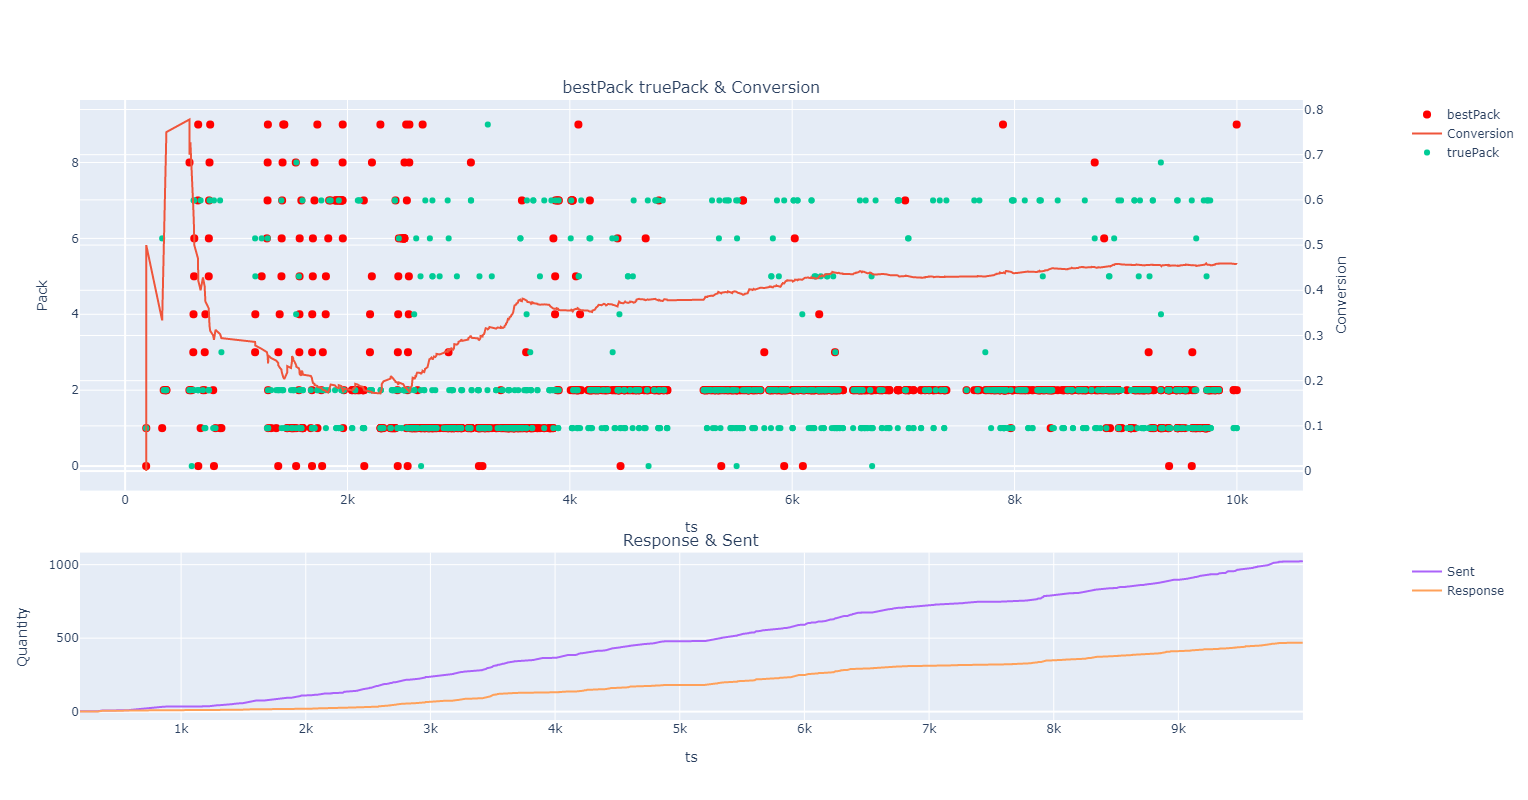

Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил) 
 100 мин на номера России (1 мес)


In [77]:
## Sent, Responce, Conversion over timeLine
CommonChart(complLeadsShort2, topic, pack)

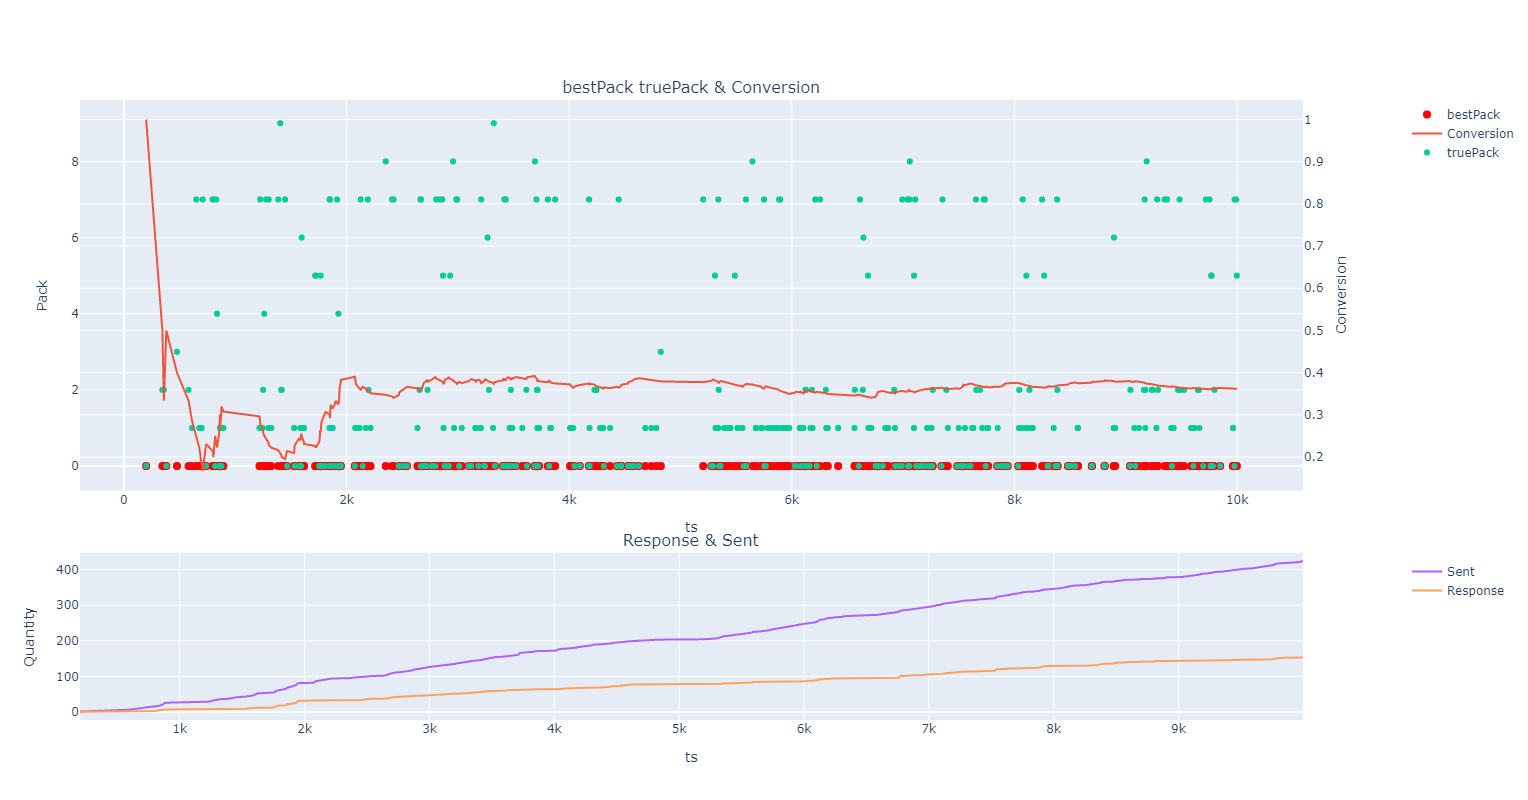

Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала 
 100 мин на номера России (1 мес)


In [66]:
CommonChart(complLeadsShort0, topic, pack)

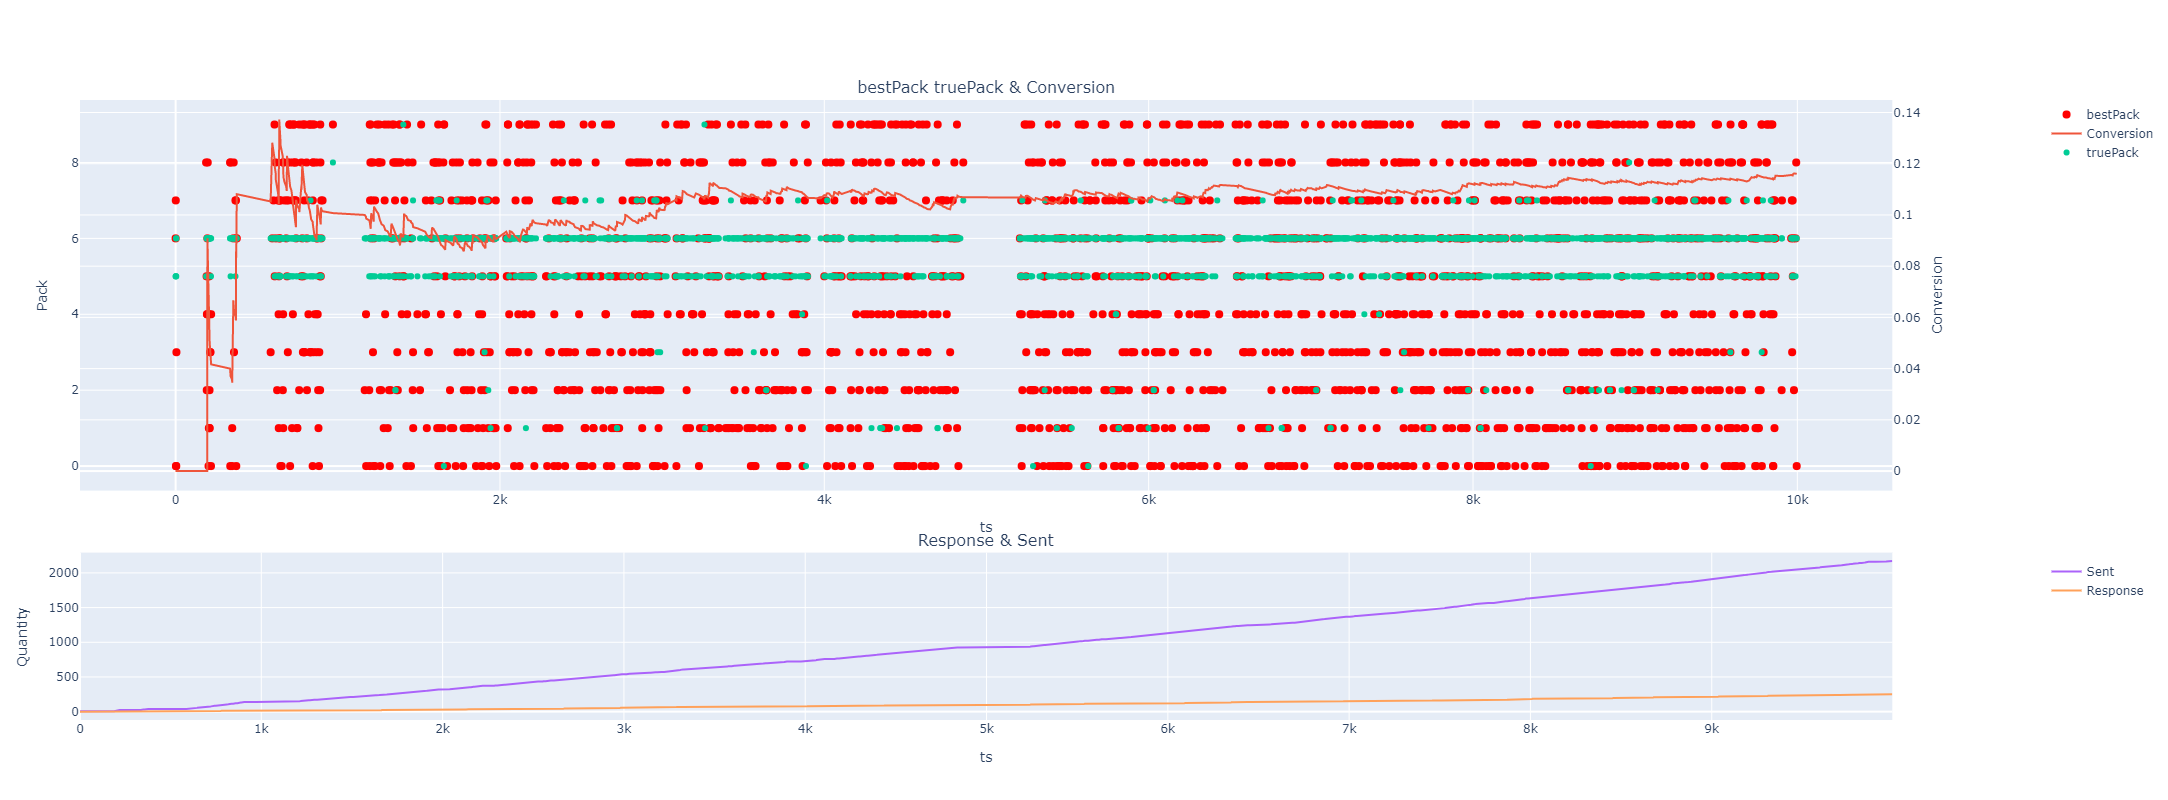

Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана 
 100 мин на номера России (1 мес)


In [41]:
CommonChart(complLeadsShort1, topic, pack)

# Dynamic env.

In [90]:
## Subs profile 
# На численных фичах постоить кластеризацию! Замечание!!
# Простая модель supervised 
#Сейчас агент учится впроизводить действия оператора 

dt1 = complLeads[ATTR_NAMES]
dt1.iloc[:, :21]
print('Используемые фичи для анализа: ', ATTR_NAMES)

,LIFE_TIME_scaled,CURRENT_AGE_scaled,ARPU_3M_scaled,ARPU_1M_scaled,BALANCE_MAX_scaled,BALANCE_MIN_scaled,BALANCE_AVG_scaled,BALANCE_KRTS_scaled,BALANCE_SKEW_scaled,VOICE_scaled,SMS_scaled,MMS_scaled,DATA_scaled,FOUR_G_scaled
0,0.20,0.09,0.83,0.92,0.49,0.60,0.51,0.36,0.52,0.00e+00,1.22e-03,0.0,7.78e-03,0.00e+00
1,0.05,0.07,0.83,0.92,0.49,0.61,0.51,0.36,0.52,2.80e-05,2.66e-04,0.0,1.44e-04,1.73e-04
2,0.50,0.07,0.83,0.92,0.49,0.60,0.51,0.36,0.52,1.19e-02,3.77e-03,0.0,4.36e-03,4.42e-03
3,0.03,0.08,0.83,0.92,0.49,0.61,0.51,0.36,0.52,4.54e-04,2.61e-04,0.0,2.31e-04,0.00e+00
4,0.28,0.06,0.83,0.92,0.49,0.60,0.51,0.36,0.52,2.25e-01,1.42e-01,0.0,3.68e-02,7.19e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51810,0.42,0.06,0.83,0.92,0.49,0.60,0.51,0.36,0.52,2.12e-02,1.48e-02,0.0,2.11e-03,5.48e-03
51811,0.14,0.05,0.83,0.92,0.49,0.60,0.51,0.36,0.52,3.18e-02,5.21e-02,0.0,3.77e-02,2.72e-02
51812,0.07,0.05,0.83,0.92,0.49,0.60,0.51,0.36,0.52,2.94e-02,2.19e-02,0.0,1.75e-02,2.59e-02
51813,0.30,0.07,0.83,0.92,0.49,0.60,0.51,0.36,0.52,5.89e-02,4.03e-02,0.0,3.34e-02,2.36e-02


Используемые фичи для анализа:  ['LIFE_TIME_scaled', 'CURRENT_AGE_scaled', 'ARPU_3M_scaled', 'ARPU_1M_scaled', 'BALANCE_MAX_scaled', 'BALANCE_MIN_scaled', 'BALANCE_AVG_scaled', 'BALANCE_KRTS_scaled', 'BALANCE_SKEW_scaled', 'VOICE_scaled', 'SMS_scaled', 'MMS_scaled', 'DATA_scaled', 'FOUR_G_scaled']


<Figure size 3600x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

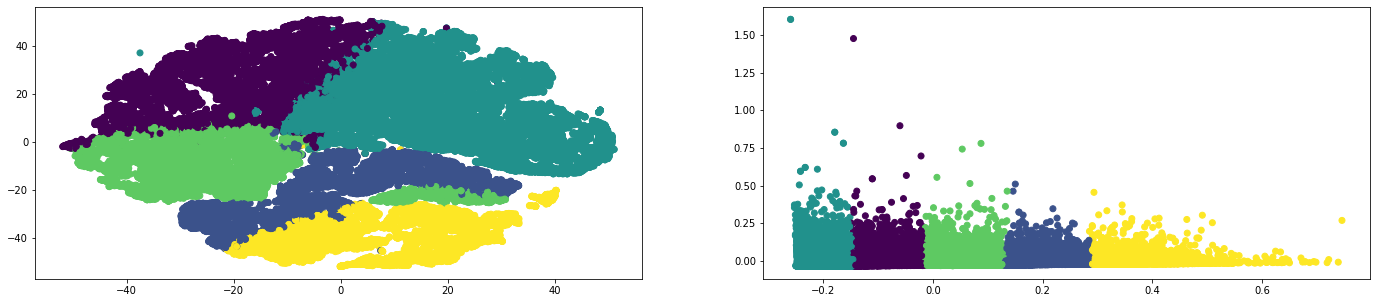

In [77]:
## Draw clusters 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_tsne = []
X_kpca = []

X_tsne = TSNE(learning_rate=100).fit_transform(dt1[ATTR_NAMES])
pca_cifar =PCA(n_components=2) 
X_pca = pca_cifar.fit_transform(dt1[ATTR_NAMES])
y = dt1['class']

plt.figure(figsize=(50, 5))
plt.subplot(141)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.subplot(142)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)


In [18]:
print('Explained variation per principal component: {}'.format(pca_cifar.explained_variance_ratio_))

Explained variation per principal component: [0.92160053 0.04694632]


## Причины обращений с кластерами абонентов

In [91]:
_Sc = complLeads[complLeads['Тема'].isin(set(_S['Тема']))].groupby(by=['Тема', 'class']).count()['MSISDN'].reset_index()
_Sc['Тема'] = _Sc.apply(lambda x: x['Тема']+'_'+str(x['class']), axis=1) 
_Sc.drop('class',axis=1, inplace=True)
_Sc = _Sc.append({'Тема':'Прочее',  'MSISDN':0}, ignore_index=True)
_Sc = _Sc.append({'Тема':'Отклик',  'MSISDN':0}, ignore_index=True)
_Sc = _Sc.append({'Тема':'Отказ',  'MSISDN':0}, ignore_index=True)    
_Sc    

,Тема,MSISDN
0,Недовольство\Интернет\Мобильный Интернет\Низкая скорость_0,404
1,Недовольство\Интернет\Мобильный Интернет\Низкая скорость_1,184
2,Недовольство\Интернет\Мобильный Интернет\Низкая скорость_2,714
3,Недовольство\Интернет\Мобильный Интернет\Низкая скорость_3,338
4,Недовольство\Интернет\Мобильный Интернет\Низкая скорость_4,233
5,Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала_0,308
6,Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала_1,221
7,Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала_2,420
8,Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала_3,262
9,Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала_4,257


In [92]:
Qc = init_q(len(_Sc), len(_A), 'ones')
pdQc = pd.DataFrame(Qc)
pdQc.index = _Sc['Тема']
pdQc.rename(columns = _A['Наименование пакета'], inplace=True)
#HeatMapDataFrame(pdQc[:-3])


In [107]:
## Ограничение данных для анализа 
complLeadsC = complLeadsShort.copy() 
complLeadsC['Тема'] = complLeadsC.apply(lambda x: x['Тема']+'_'+str(x['class']), axis=1) 

In [101]:
%%time
import plotly.express as px
## Main procerure
#complLeadsC, convHistC = mainRL(_Sc, _A, complLeadsC,)
complLeadsC, convHistC, Qc = mainRL(_S, _A, complLeadsC, 0.95, episodes, _Q=None,)

Wall time: 35.1 s


In [110]:
complLeadsC['Тема'] = complLeadsC.apply(lambda x: x['Тема'][:-2], axis=1) 

In [109]:
complLeadsC.apply(lambda x: x['Тема'][:-2], axis=1) 

0                                                                                Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
1                                                                                Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
2                                                                                Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
3                                                                                                                   Претензия устная\Интернет\Мобильный Интернет\Низкая скорость
4                                                                                Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана
                                                                                          ...                      

In [114]:
## Quantities & conversion per topics
index = episodes
convTopic3 = complLeadsC[:index].groupby('Тема').agg({'MSISDN':len, 'reward':PosPerc})
#convTopic2
conPairsC = pd.concat([convTopic2,convTopic3], axis=1)
symbols = ['allQ', 'conv2', 'allQ3', 'conv3']
conPairsC.columns = symbols
conPairsC['lift'] = conPairsC['conv3']/conPairsC['conv2']
conPairsC[['allQ','conv2','conv3','lift']].sort_values(by='lift',ascending=False)

,allQ,conv2,conv3,lift
Тема,,,,
Недовольство\Покрытие/Сеть\Зона обслуживания/Покрытие\Ухудшение привычного уровня сигнала,424,0.27,0.33,1.22
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности с управлением продуктами в ЛК/МЛК В2С,735,0.49,0.58,1.18
"Недовольство\Тарифные планы\Для массового рынка\Требование возврата АП (не использовал, ошибочно подключил)",1025,0.42,0.45,1.08
Недовольство\Тарифные планы\Для массового рынка\Недовольство текущими условиями тарифного плана,2172,0.66,0.69,1.04
Претензия устная\Системы самообслуживания\ЛК/МЛК (В2С) самостоятельное управление услугами\Сложности со входом в ЛК/МЛК B2С,210,0.85,0.86,1.02
Претензия устная\Тарифные планы\Для массового рынка\(для ИТ) Некорректное списание АП,1214,0.64,0.61,0.95
"Претензия устная\Абонентское обслуживание\(КЦ)Требует старшего, угрожает обращением директору/в суд и др\Требует возврат (по инструкции возврат недоступен, не репрайс)",1214,0.31,0.24,0.78
Недовольство\Интернет\Мобильный Интернет\Низкая скорость,577,0.34,0.07,0.22
Претензия устная\Интернет\Мобильный Интернет\Низкая скорость,1445,0.47,0.06,0.13


In [25]:
cLc = complLeadsC.groupby(by=['Тема','class']).agg({'pred':sum, 'MSISDN':len}).copy()
cLc['perc'] = cLc['pred']/cLc['MSISDN']
cLc

pred  MSISDN  perc
Тема                                               class                     
Недовольство\Интернет\Мобильный Интернет\Низкая... 0       24.0      92  0.26
                                                   1       75.0     339  0.22
                                                   2       40.0     184  0.22
                                                   3       21.0      67  0.31
                                                   4       47.0     134  0.35
...                                                         ...     ...   ...
Претензия устная\Тарифные планы\Для массового р... 0       99.0     184  0.54
                                                   1      330.0     543  0.61
                                                   2      142.0     247  0.57
                                                   3      106.0     187  0.57
                                                   4      163.0     269  0.61

[50 rows x 3 columns]